#**image segmentation of mould spores from grayscale microscope images**

**StarDist**

- cell segmentation models
- traind on microscope images dataset '2D_versatile_he'


## imports, mount drive and directory paths

In [1]:
##imports
# google drive
from google.colab import drive
#________________________________________________________________________________

# openCV and PIL
!pip install "opencv-python-headless<4.3"
import cv2 as cv
#________________________________________________________________________________

# tensorflow and keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import Input, Conv2D, Reshape
from keras.models import Model
from keras.models import Model, Sequential
# from tensorflow.keras.metrics import MeanIoU

#________________________________________________________________________________

# albumentations
!pip install --upgrade git+https://github.com/albumentations-team/albumentations
import albumentations as A
#________________________________________________________________________________

# others 
import os
import numpy as np
from random import sample
from glob import glob
import matplotlib.pyplot as plt 
import pandas as pd
#________________________________________________________________________________

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
#________________________________________________________________________________

#pytorch
from torch import stack
#_______________________________________________________________________________

#  stardist
!pip install stardist
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.plot import render_label
from stardist.matching import matching, matching_dataset
import stardist
from stardist import _draw_polygons
from stardist import fill_label_holes

# csbdeep
from csbdeep.utils.tf import keras_import
# from csbdeep.internals.nets import common_unet, custom_unet
# from csbdeep.internals.blocks import unet_block, resnet_block
from csbdeep.models import BaseModel, BaseConfig
from csbdeep.utils import normalize

#  stardist
!pip install stardist
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.plot import render_label
from stardist.matching import matching
import stardist
from stardist import _draw_polygons


     |████████████████████████████████| 21.6 MB 1.7 MB/s 
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-gnpwh7am
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-gnpwh7am
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=2408446dcf7a27d376f33463bb1d62233a9a6011cc462b529be94c167b450662
  Stored in directory: /tmp/pip-ephem-wheel-cache-5p49_wfn/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 3.0 MB 26.8 MB/s 
     |████████████████████████████████| 73 kB 2.4 MB/s 
     |████████████████████████████████| 2.9 MB 58.8 MB/s 
  Attempting uninstall: h5py
    Found existing 

In [2]:
print(A.__version__)

1.1.0


In [3]:
##mount drive
# unmount drive to refresh directories
drive.flush_and_unmount()

print('drive unmounted')

# mount drive
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
drive unmounted
Mounted at /content/drive


In [4]:
## directory paths
DIR_IMGS = '/content/drive/MyDrive/Spores/images'
# DIR_FXD_LBLS = '/content/drive/MyDrive/Spores/fixed masks'
# DIR_AUG_IMGS = '/content/drive/MyDrive/Spores/train images'
# DIR_AUG_LBLS = '/content/drive/MyDrive/Spores/train masks'
DIR_LBLS = '/content/drive/MyDrive/Spores/masks'
# DIR_VAL_IMGS = '/content/drive/MyDrive/Spores/validation images'
# DIR_VAL_LBLS = '/content/drive/MyDrive/Spores/validation masks'

## data exploration

In [5]:
#set images input shape as the largest input image
img_height, img_width = 100, 100 

In [6]:
## check for unfixed masks and unequal shapes
def check_data(X_, y_, names):

  for X, y, name in zip(X_, y_, names):
    if (y.any() != 0) ^ (y.any() != 255):
      print(f'{name} unfixed mask')
    if y.shape != X.shape:
      print(f'{name} unequal shapes')
    if X.shape != (img_height, img_width, 3):
      print(f'{name} image is in shape {X.shape}')
    if X.shape != (img_height, img_width, 3):
      print(f'{name} mask is in shape {y.shape}')




  print(f'there are {len(X_)} samples')

In [7]:
## number of images in directory
len(os.listdir(DIR_IMGS))

942

In [8]:
## create a data frame of names and their coresponding images and masks

names = []
X = []
y = []
X_shape = []
y_shape = []


for name in os.listdir(DIR_IMGS):
  path = f'{DIR_IMGS}/{name}'
  mask_path = f'{DIR_LBLS}/{name}'
  img = cv.imread(path)
  msk = cv.imread(mask_path)

  names.append(name)
  X.append(img)
  y.append(msk)

data = pd.DataFrame()
data['name'] = names
data['X'] = X
data['y'] = y


In [9]:
## check for images and masks with unequal shapes
check_data(data['X'], data['y'], data['name'])

07_09_20_1_CB_151.png image is in shape (88, 88, 3)
07_09_20_1_CB_151.png mask is in shape (88, 88, 3)
07_09_20_1_CB_46.png image is in shape (93, 93, 3)
07_09_20_1_CB_46.png mask is in shape (93, 93, 3)
07_09_20_1_CB_83.png image is in shape (84, 84, 3)
07_09_20_1_CB_83.png mask is in shape (84, 84, 3)
07_09_20_1_CB_3.png image is in shape (81, 81, 3)
07_09_20_1_CB_3.png mask is in shape (81, 81, 3)
07_09_20_1_CB_19.png image is in shape (74, 74, 3)
07_09_20_1_CB_19.png mask is in shape (74, 74, 3)
07_09_20_1_CB_168.png image is in shape (84, 84, 3)
07_09_20_1_CB_168.png mask is in shape (84, 84, 3)
07_09_20_1_CB_161.png image is in shape (80, 80, 3)
07_09_20_1_CB_161.png mask is in shape (80, 80, 3)
07_09_20_1_CB_35.png image is in shape (87, 87, 3)
07_09_20_1_CB_35.png mask is in shape (87, 87, 3)
07_09_20_1_CB_174.png image is in shape (85, 85, 3)
07_09_20_1_CB_174.png mask is in shape (85, 85, 3)
07_09_20_1_CB_68.png image is in shape (92, 92, 3)
07_09_20_1_CB_68.png mask is in sh

In [10]:
# filter samples with unequal shapes
data['equal shapes'] = [X_.shape == y_.shape for X_, y_ in zip(data['X'], data['y'])]
equal_data = data[data['equal shapes']].drop(columns = ['equal shapes'])
check_data(equal_data['X'], equal_data['y'], equal_data['name'])

07_09_20_1_CB_151.png image is in shape (88, 88, 3)
07_09_20_1_CB_151.png mask is in shape (88, 88, 3)
07_09_20_1_CB_46.png image is in shape (93, 93, 3)
07_09_20_1_CB_46.png mask is in shape (93, 93, 3)
07_09_20_1_CB_83.png image is in shape (84, 84, 3)
07_09_20_1_CB_83.png mask is in shape (84, 84, 3)
07_09_20_1_CB_3.png image is in shape (81, 81, 3)
07_09_20_1_CB_3.png mask is in shape (81, 81, 3)
07_09_20_1_CB_19.png image is in shape (74, 74, 3)
07_09_20_1_CB_19.png mask is in shape (74, 74, 3)
07_09_20_1_CB_168.png image is in shape (84, 84, 3)
07_09_20_1_CB_168.png mask is in shape (84, 84, 3)
07_09_20_1_CB_161.png image is in shape (80, 80, 3)
07_09_20_1_CB_161.png mask is in shape (80, 80, 3)
07_09_20_1_CB_35.png image is in shape (87, 87, 3)
07_09_20_1_CB_35.png mask is in shape (87, 87, 3)
07_09_20_1_CB_174.png image is in shape (85, 85, 3)
07_09_20_1_CB_174.png mask is in shape (85, 85, 3)
07_09_20_1_CB_68.png image is in shape (92, 92, 3)
07_09_20_1_CB_68.png mask is in sh

## data pipeline



In [11]:
# mask kernel for labels dilution
dilution_kernel = (3,3)
#________________________________________________________________________________

# number of dilution iterations for labels dilution
dilution_iterations = 2
#________________________________________________________________________________


### mask fix
blacken all non-white pixels in all masks

In [12]:
# function that fix mask images with specified dilution parameters
def fix_mask(image, dilution_kernel = dilution_kernel,
             dilution_iterations = dilution_iterations):

   thresh = image.copy()
   thresh[thresh != 255] = 0
   thresh_dilate = cv.dilate(thresh, 
                             kernel = dilution_kernel,
                             iterations = dilution_iterations)
   return thresh_dilate

In [13]:
## fix masks 
fixed_y = equal_data['y'].apply(lambda y : fix_mask(y))
fixed_data = equal_data.copy()
fixed_data['y'] = fixed_y

In [14]:
check_data(fixed_data['X'], fixed_data['y'], fixed_data['name'])

07_09_20_1_CB_151.png image is in shape (88, 88, 3)
07_09_20_1_CB_151.png mask is in shape (88, 88, 3)
07_09_20_1_CB_46.png image is in shape (93, 93, 3)
07_09_20_1_CB_46.png mask is in shape (93, 93, 3)
07_09_20_1_CB_83.png image is in shape (84, 84, 3)
07_09_20_1_CB_83.png mask is in shape (84, 84, 3)
07_09_20_1_CB_3.png image is in shape (81, 81, 3)
07_09_20_1_CB_3.png mask is in shape (81, 81, 3)
07_09_20_1_CB_19.png image is in shape (74, 74, 3)
07_09_20_1_CB_19.png mask is in shape (74, 74, 3)
07_09_20_1_CB_168.png image is in shape (84, 84, 3)
07_09_20_1_CB_168.png mask is in shape (84, 84, 3)
07_09_20_1_CB_161.png image is in shape (80, 80, 3)
07_09_20_1_CB_161.png mask is in shape (80, 80, 3)
07_09_20_1_CB_35.png image is in shape (87, 87, 3)
07_09_20_1_CB_35.png mask is in shape (87, 87, 3)
07_09_20_1_CB_174.png image is in shape (85, 85, 3)
07_09_20_1_CB_174.png mask is in shape (85, 85, 3)
07_09_20_1_CB_68.png image is in shape (92, 92, 3)
07_09_20_1_CB_68.png mask is in sh

### resize to 100x100 
by padding images and masks which are smaller
images are padded by constant mean value while masks are padded by constant 0 (black)

In [15]:
## a function that padds the images and masks to a certain size (100X100)
def pad_arr(arr, to_height = img_height, to_width = img_width):

  # if image is not in the right size
  if arr.shape != (img_height,img_width,3):     

    # calculate padding
    pad_size = ((0,to_height - arr.shape[0]), (0,to_width - arr.shape[1]), (0,0))

    return np.pad(arr, pad_size, mode = 'reflect')

  return arr

In [16]:
padd_X = fixed_data['X'].apply(lambda x : pad_arr(x))
padd_y = fixed_data['y'].apply(lambda y : pad_arr(y))

padd_data = fixed_data.copy()
padd_data['X'] = padd_X
padd_data['y'] = padd_y


In [17]:
check_data(padd_data['X'], padd_data['y'], padd_data['name'])

there are 929 samples


### normalize 

In [18]:
## axis normalization parameters
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly

In [19]:
# normalize data - StarDist uses notmalization of (1, 99.8) 
norm_data = pd.DataFrame()
norm_data['X'] = [normalize(x,1,99.8,axis=axis_norm).astype('float32') for x in padd_data['X']]
norm_data['y'] = [y.astype('float32') for y in padd_data['y']]
                

In [20]:
## check for unfixed masks and unequal shapes 
def check_fixed_data(X_, y_):

  for X, y, ind in zip(X_, y_, range(len(X_))):
    if (y.any() != 0) ^ (y.any() != 255):
      print(f'{ind}# unfixed mask')
    if y.shape != X.shape:
      print(f'{ind}# unequal shapes')
    if X.shape != (img_height, img_width,3):
      print(f'{ind}# image is in shape {X.shape}')
    if X.shape != (img_height, img_width,3):
      print(f'{ind}# mask is in shape {y.shape}')


  print(f'there are {ind} samples')
  

In [21]:
X = list(norm_data['X'])
y = list(norm_data['y'])

In [22]:
check_fixed_data(X, y)

there are 928 samples


In [23]:
def check_dim_shape_type(X, y):
  # for i,j in zip(X, y):
  #   if i.ndim != j.ndim:
  #     print('dim', i.ndim, j.ndim)
  #   if i.shape != j.shape:
  #     print('shape', i.shape, j.shape)
  print(f'dim X: {X[0].ndim}, dim y: {y[0].ndim}')
  print(f'shape X: {X[0].shape}, shape y: {y[0].shape}')
  print(f'type X: {X[0].dtype}, type y: {y[0].dtype}')
  print(f'{len(X)} samples')
      

In [24]:
check_dim_shape_type(X, y)

dim X: 3, dim y: 3
shape X: (100, 100, 3), shape y: (100, 100, 3)
type X: float32, type y: float32
929 samples


## prediction with 2D stardist model, pretrained on 2D_versatile_he dataset
taken from https://github.com/stardist/stardist



In [25]:
## create pretraind model
pt_model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
5308416/5294730 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [26]:
def example(model, img, msk, show_dist=True):

    labels, details = model.predict_instances(img)
    
    # plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    msk_show = msk if msk.ndim==2 else msk[...,0]

    coord, points, prob = details['coord'], details['points'], details['prob']

    plt.subplot(1,3, 1); plt.imshow(img_show, cmap='gray'); plt.axis('off') ; plt.title('prediction')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)

    plt.subplot(1,3,2); plt.imshow(img_show, cmap='gray'); plt.axis('off') ; plt.title('image')
    # plt.imshow(labels, cmap= 'tab20c', alpha=0.5)
    plt.tight_layout()

    plt.subplot(1,3,3); plt.imshow(msk_show, cmap='gray'); plt.axis('off') ; plt.title('true mask')
    # plt.imshow(labels, cmap= 'tab20c', alpha=0.5)
    plt.tight_layout()
    plt.show()

#720, image shape: (100, 100, 3), mask shape: (100, 100, 3)
#720, image type: float32, mask type: float32


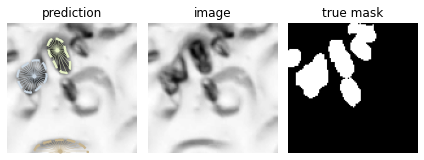

#546, image shape: (100, 100, 3), mask shape: (100, 100, 3)
#546, image type: float32, mask type: float32


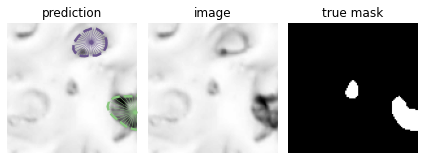

#195, image shape: (100, 100, 3), mask shape: (100, 100, 3)
#195, image type: float32, mask type: float32


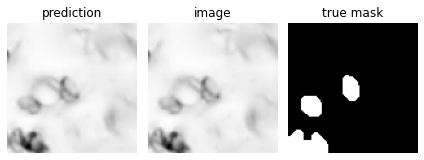

#696, image shape: (100, 100, 3), mask shape: (100, 100, 3)
#696, image type: float32, mask type: float32


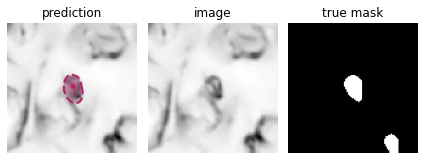

#695, image shape: (100, 100, 3), mask shape: (100, 100, 3)
#695, image type: float32, mask type: float32


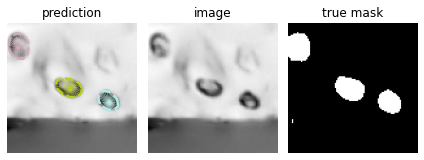

In [27]:
## show predictions examples
sample_index_lst = sample(list(range(len(X))), 5)

for ind in sample_index_lst:
  img = X[ind]
  msk = y[ind]
  print(f'#{ind}, image shape: {img.shape}, mask shape: {msk.shape}')
  print(f'#{ind}, image type: {img.dtype}, mask type: {msk.dtype}')
  example(pt_model,img,msk,show_dist=True)

In [28]:
## make predictions
y_pred = np.array([pt_model.predict_instances(x, n_tiles=pt_model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in X], dtype = int)

## model evaluation

In [29]:
## make y_1c as array of one channel arrays of intigers 
# (this transformation is needed for matching the requirement input for 'matching_dataset' function,
# y_1c is similar to y but with dtype = int and in shape of (100,100))
y_1c = [np.array(y_[:,:,0], dtype = int) for y_ in y]

In [40]:
def compute_iou(y_pred, y_true):
  ious_0 = []
  ious_1 = []
  ious = []
  for i,j in zip(y_pred, y_true):
    pred = np.array(i > 0, dtype = int)
    true = np.array(j == 255, dtype = int)

    # ytrue, ypred is a flatten vector
    pred_ = pred.flatten()
    true_ = true.flatten()

    labels = [0, 1]
    jaccards = []

    jaccard_0 = jaccard_score(pred_.flatten(),true_.flatten(), pos_label=0)
    jaccard_1 = jaccard_score(pred_.flatten(),true_.flatten(), pos_label=1)
    
    ious_0.append(jaccard_0)
    ious_1.append(jaccard_1)
    ious.append((jaccard_0 + jaccard_1)/2)

  iou_0 = np.mean(jaccard_0)
  iou_1 = np.mean(jaccard_1)
  
  print(f'mean IoU of background: {np.mean(iou_0)}')
  print(f'median IoU of background: {np.median(iou_0)}')

  plt.hist(ious_0) ; plt.title('background IoU') ; plt.xlabel('sample Jaccard score') ; plt.ylabel('number of samples')
  plt.show()

  print(f'mean IoU of spores: {np.mean(iou_1)}')
  print(f'median IoU of spores: {np.median(iou_1)}')

  plt.hist(ious_1) ; plt.title('spores IoU') ; plt.xlabel('sample Jaccard score') ; plt.ylabel('number of samples')
  plt.show()

  print(f'mean IoU: {np.mean(ious)}')
  print(f'median IoU: {np.median(ious)}')

  plt.hist(ious) ; plt.title('model IoU') ; plt.xlabel('sample Jaccard score') ; plt.ylabel('number of samples')
  plt.show()


mean IoU of background: 0.9817997977755308
median IoU of background: 0.9817997977755308


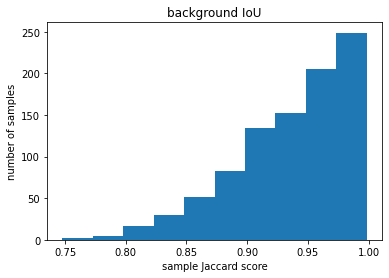

mean IoU of spores: 0.3793103448275862
median IoU of spores: 0.3793103448275862


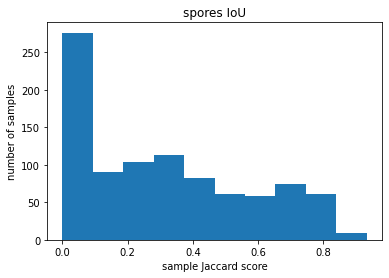

mean IoU: 0.6213720463983281
median IoU: 0.5999980371801694


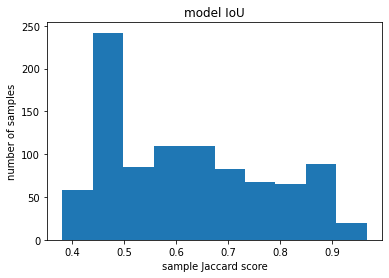

In [41]:
compute_iou(y_pred, y_1c)